# Clase 4: Simulación del modelo de precios 

Prof. Tito Homem-de-Mello

In [1]:
install.packages('tidyr')
install.packages('ggplot2')
install.packages('data.table')

Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

also installing the dependencies ‘generics’, ‘dplyr’


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)

also installing the dependencies ‘colorspace’, ‘farver’, ‘labeling’, ‘munsell’, ‘RColorBrewer’, ‘viridisLite’, ‘gtable’, ‘isoband’, ‘scales’


Installing package into ‘/srv/rlibs’
(as ‘lib’ is unspecified)



In [3]:
library(purrr)
library(ggplot2)
library(data.table)

### Parámetros del modelo

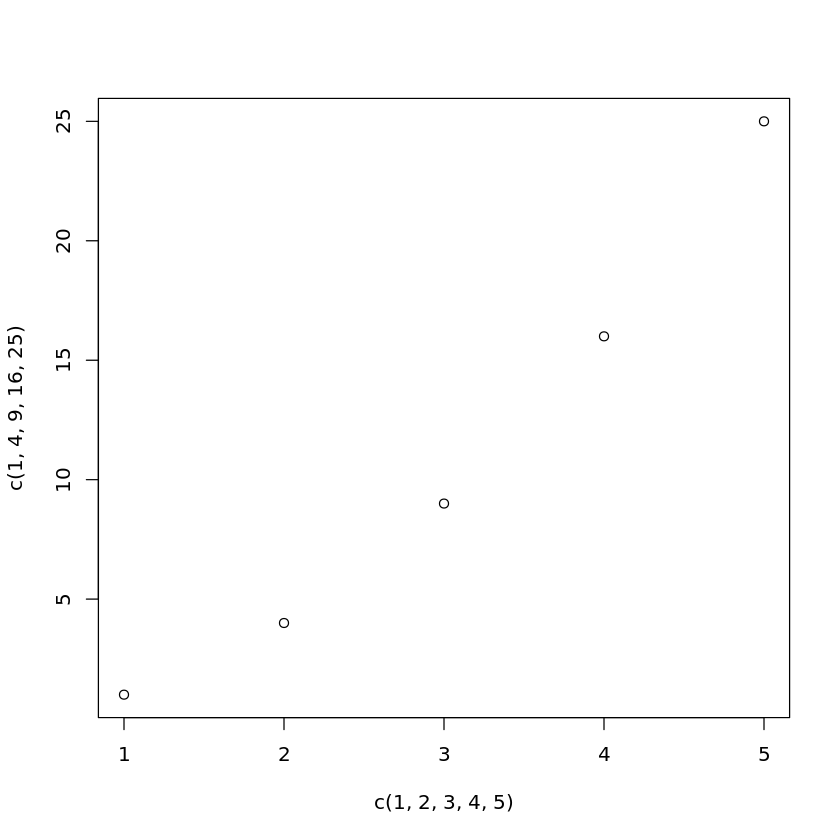

In [4]:
plot(c(1,2,3,4,5),c(1,4,9,16,25))

In [9]:
x=seq(-pi,pi,0.1)
y=sin(x)

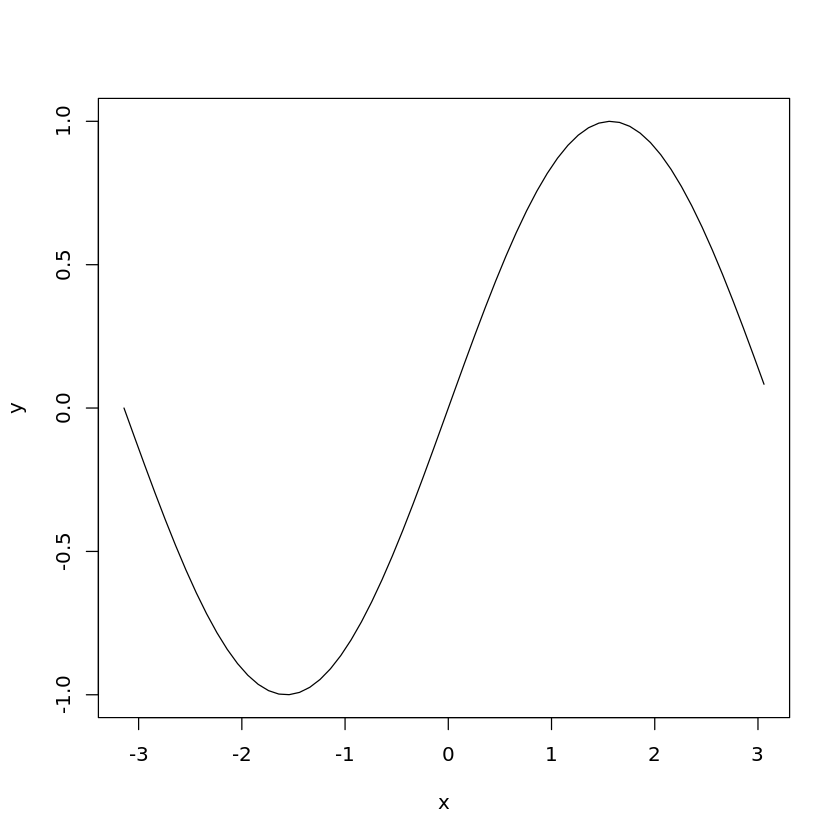

In [10]:
plot(x,y,type='l')

In [ ]:
P0 <- 100  #Precio actual
mu <- 0.08 #Drift (anual)
sigma <- 0.12 #Volatilidad (anual)
T <- 0.5 #Horizonte (años)

## Empecemos con una simulación de los precios apenas en el periodo final $T$

### Generamos $N$ muestras de los precios en el periodo $T$: $$P(T)=P(0)\exp\left((\mu-\sigma^2/2)T+\sigma\sqrt{T}\,Z\right), \quad Z\sim \text{Normal}(0,1)$$

In [ ]:
N <- 500
log_cambio <- (mu-sigma^2/2)*T + sigma*sqrt(T)*rnorm(N,0,1)
PT <- P0*exp(log_cambio)

### Extraimos los precios, veamos un histograma

In [ ]:
bin <- 5
plotfig <- ggplot(as.data.frame(PT),aes(PT))+
        theme(plot.title = element_text(size = 15),
              axis.title.y=element_text(size = 20),
              axis.title.x=element_text(size = 20))
 
p <- plotfig+geom_histogram(aes(y = after_stat(count /(sum(count)))), binwidth=bin, color="black", fill="gray")+
       labs(x="precio",
            y="frecuencia",
            title=paste0("Histograma de las ",N," simulaciones del precio final"))

#p <- p+ geom_vline(aes(xintercept=mean(PT)),
#            color="blue", linetype="dashed", size=1)
           
p 

### Ahora veamos un boxplot

In [ ]:
plotfig+ geom_boxplot(fill="gray")+
         labs(x="precio",
              title=paste0("Boxplot de las ",N," simulaciones del precio final"))

### Calculemos cuantiles

In [ ]:
quantile(PT,probs=0.60) 

### Veamos el gráfico de la cdf empirica

In [ ]:
pfin <-  plotfig+geom_function(fun=ecdf(PT))+
         xlim(70,140)+
         labs(x="precio",y="F_N(x)",
              title=paste0("Distr. empírica de las ",N," simulaciones del precio final")) 
pfin

### Porcentaje de datos menor que un valor específico (p.e. \$105)

In [ ]:
e <- ecdf(PT)  #función distribución empírica 

sprintf("Probabilidad que precio final<=%5.2f = %5.2f",105,e(105))

### Calculemos un intervalo de confianza para el precio ESPERADO en $T$

In [ ]:
m <- mean(PT)
lower <- m-1.96*sd(PT)/sqrt(N)
upper <- m+1.96*sd(PT)/sqrt(N)

sprintf("Media=%5.2f",m)
sprintf("Intervalo de confianza 95%%: [%5.2f,%5.2f]",lower,upper)

### ¿Qué concluimos? ¿Que en  PROMEDIO el precio de esa acción sube en torno a 4%?

### OJO! No podemos comparar valores monetarios en periodos distintos. Hay que corregirlos usando una tasa de descuento $r$:

### $P_0(t)=P(t)*e^{-rt}$   (valor $P(t)$ en el periodo 0)

### o

### $P_t(0)=P(0)*e^{rt}$   (valor $P(0)$ en el periodo t)

### Por ejemplo, el valor del precio inicial corregido a $T=$6 meses (=$0,5$ años), a una tasa anual de $r$=3%, es

### $P_T(0)=P(0)*e^{rT}$

In [ ]:
r <- 0.03  #Tasa anual
P0_T  <- P0*exp(r*0.5)
sprintf("Precio inicial corregido al periodo T=%5.2f",P0_T)

## Ploteemos ahora una evolución de precios

### Tenemos que generar los precios para cada semana; para ello, generamos el precio de la semana $t$ (o sea, periodo $t/52$) en función del precio en la semana $t-1$ (periodo $(t-1)/52$): $$P(t)=P(t-1)\exp\left((\mu-\sigma^2/2)\frac{1}{52}+ \sigma\sqrt{\frac{1}{52}}\,Z_t, \quad Z_t\sim \text{Normal}(0,1)\right)$$

In [ ]:
set.seed(123)
N <- 501

nsem <- 26 #Nro de semanas en T=6 meses
nsem_anio <- 52 #Nro de semanas en un anio
precios <- array(rep(0,N*(nsem+1)),dim=c(N,nsem+1))
precios[,1] <- P0
for (t in 1:nsem)
    {
      log_cambio <- (mu-sigma^2/2)*(1/nsem_anio) + sigma*sqrt(1/nsem_anio)*rnorm(N,0,1)
      precios[,t+1] <- precios[,t]*exp(log_cambio)
    }



In [ ]:
Nsim <-500
precios_df <- as.data.frame(precios[1:(Nsim+1),])
names(precios_df) <- 0:nsem
precios_df$n <- 1:(Nsim+1)
plotdata <- precios_df %>% tidyr::gather("semana", "precio",0:nsem+1) 
plotdata <- data.table(plotdata)
plotfig <- ggplot(plotdata[n<=Nsim], aes(as.numeric(semana),precio,group=n,color=n)) +
            geom_line(show.legend = F)+
            ylim(70,140)+
            theme(plot.title = element_text(size = 15),
                  axis.title.y=element_text(size = 20),
                  axis.title.x=element_text(size = 20))+
            labs(y="Precio",
                x="Semana",
                title=paste0("Gráfico de precios para ",Nsim," simulaciones de ",nsem," semanas"))

rsem <- r/nsem_anio #tasa semanal
cons <- data.frame(n=N+1,semana=0:nsem,precio=P0*exp(rsem*(0:nsem))) #Para graficar valor constante=P0 corregido
plotfig+geom_line(data=cons,color="red")

### Veamos un histograma de los precios en una semana arbitraria

In [ ]:
sem=10 #nsem
plotfig <- ggplot(plotdata[(semana==sem) & (n<=Nsim)],aes(precio))+
        theme(plot.title = element_text(size = 13),
              axis.title.y=element_text(size = 20),
              axis.title.x=element_text(size = 20))
 
p <- plotfig+geom_histogram(aes(y = after_stat(count / sum(count))), binwidth=5, color="black", fill="gray")+
       labs(x="precio",
            y="frecuencia",
            title=paste0("Histograma de las ",Nsim," simulaciones del precio en la semana ",sem))

p <- p+ geom_vline(aes(xintercept=P0*exp(rsem*sem)), #Valor inicial corregido a la semana indicada
            color="red", linetype="dashed", size=1)
            
p 

### Veamos la distribución empírica en el periodo final

In [ ]:
plotfig_emp <- plotfig+geom_function(fun=ecdf(plotdata[(semana==nsem) & (n<=Nsim),precio]), color="black")+
                xlim(70,140)+
                labs(x="precio",y="F_N(x)",
                title=paste0("Distr. empírica de las ",Nsim," simulaciones del precio final")) 
plotfig_emp


### Comparemos con la simulación anterior, cuando simulamos directamente el periodo $T$:

In [ ]:
plotfig_emp+geom_function(fun=ecdf(PT), color="red")

### Comparemos ahora ambas distribuciones con la distribución teórica, i.e. $$\frac{P(T)}{P(0)} \sim \text{Lognormal}\left((\mu-\sigma^2/2)T,\sigma\sqrt{T}\right)$$

In [ ]:
plotfig+geom_function(fun=ecdf(plotdata[(semana==nsem) & (n<=Nsim),precio]/P0), color="black")+
        geom_function(fun=ecdf(PT/P0), color="red")+
        geom_function(fun=plnorm,args=list((mu-sigma^2/2)*T,sigma*sqrt(T)),color="blue")+
        xlim(0.7,1.40)+
        labs(x="precio",y="F_N(x)",
        title=paste0("Distr. empírica de las ",Nsim," simulaciones del precio final")) 
